Epoch [1/10] - Train Loss: 0.0316, Valid Loss: 0.0193
Epoch [2/10] - Train Loss: 0.0143, Valid Loss: 0.0156
Epoch [3/10] - Train Loss: 0.0124, Valid Loss: 0.0126
Epoch [4/10] - Train Loss: 0.0106, Valid Loss: 0.0104
Epoch [5/10] - Train Loss: 0.0090, Valid Loss: 0.0103
Epoch [6/10] - Train Loss: 0.0083, Valid Loss: 0.0092
Epoch [7/10] - Train Loss: 0.0076, Valid Loss: 0.0092
Epoch [8/10] - Train Loss: 0.0071, Valid Loss: 0.0080
Epoch [9/10] - Train Loss: 0.0066, Valid Loss: 0.0079
Epoch [10/10] - Train Loss: 0.0063, Valid Loss: 0.0076


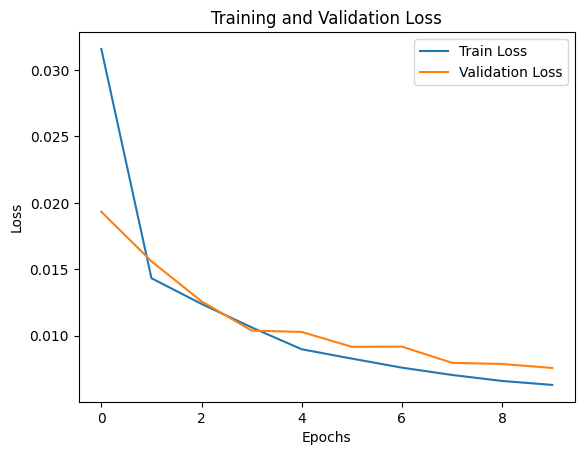

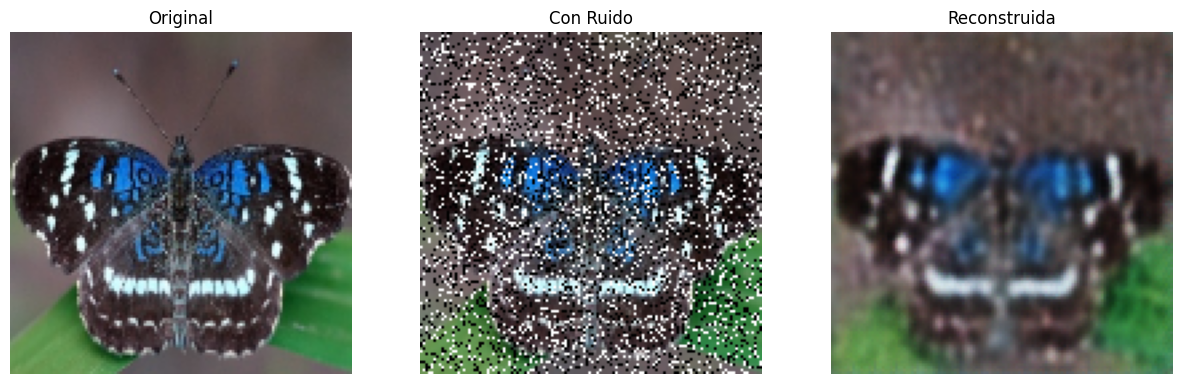

In [4]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

# Función para agregar ruido "Salt and Pepper" a las imágenes
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    total_pixels = image.size
    salt_pixels = int(salt_prob * total_pixels)
    pepper_pixels = int(pepper_prob * total_pixels)
    
    # Añadir 'sal' (píxeles blancos)
    for _ in range(salt_pixels):
        i = np.random.randint(0, image.shape[0])
        j = np.random.randint(0, image.shape[1])
        noisy_image[i, j] = 1.0
    
    # Añadir 'pimienta' (píxeles negros)
    for _ in range(pepper_pixels):
        i = np.random.randint(0, image.shape[0])
        j = np.random.randint(0, image.shape[1])
        noisy_image[i, j] = 0.0
    
    return noisy_image

# Dataset personalizado
class BirdsDataset(Dataset):
    def __init__(self, images, add_noise=False, salt_prob=0.05, pepper_prob=0.05):
        self.images = images
        self.add_noise = add_noise
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.add_noise:
            noisy_image = add_salt_and_pepper_noise(image, self.salt_prob, self.pepper_prob)
        else:
            noisy_image = image
        return torch.FloatTensor(noisy_image.transpose(2, 0, 1)), torch.FloatTensor(image.transpose(2, 0, 1))

# Cargar imágenes de las carpetas
def load_images_from_folder(folder_path):
    images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.resize(image, (128, 128))
                    image = image / 255.0
                    images.append(image)
    return np.array(images)

# Cargar datos
train_images = load_images_from_folder('archive/train')
test_images = load_images_from_folder('archive/test')
valid_images = load_images_from_folder('archive/valid')
all_images = np.concatenate([train_images, test_images, valid_images], axis=0)

# Crear datasets y dataloaders
train_dataset = BirdsDataset(train_images, add_noise=True)
valid_dataset = BirdsDataset(valid_images)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

# Autoencoder convolucional
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Entrenamiento del autoencoder
def train_autoencoder(autoencoder, train_loader, valid_loader, device, epochs=10):
    autoencoder.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        autoencoder.train()
        train_loss = 0
        for noisy_images, original_images in train_loader:
            noisy_images, original_images = noisy_images.to(device), original_images.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(noisy_images)
            loss = criterion(outputs, original_images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))

        # Validación
        autoencoder.eval()
        valid_loss = 0
        with torch.no_grad():
            for noisy_images, original_images in valid_loader:
                noisy_images, original_images = noisy_images.to(device), original_images.to(device)
                outputs = autoencoder(noisy_images)
                loss = criterion(outputs, original_images)
                valid_loss += loss.item()
        
        valid_losses.append(valid_loss / len(valid_loader))
        print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")

    return train_losses, valid_losses

# Visualización de pérdidas
def plot_losses(train_losses, valid_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

# Mostrar una muestra
def visualize_sample(autoencoder, dataset, device):
    idx = np.random.randint(len(dataset))
    noisy_image, original_image = dataset[idx]
    autoencoder.eval()
    with torch.no_grad():
        reconstructed_image = autoencoder(noisy_image.unsqueeze(0).to(device)).squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # Mostrar imágenes
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image.numpy().transpose(1, 2, 0))
    axs[0].set_title("Original")
    axs[1].imshow(noisy_image.numpy().transpose(1, 2, 0))
    axs[1].set_title("Con Ruido")
    axs[2].imshow(reconstructed_image)
    axs[2].set_title("Reconstruida")
    for ax in axs:
        ax.axis("off")
    plt.show()

# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Entrenar el autoencoder
autoencoder = ConvAutoencoder()
train_losses, valid_losses = train_autoencoder(autoencoder, train_loader, valid_loader, device, epochs=10)

# Visualizar las pérdidas
plot_losses(train_losses, valid_losses)

# Mostrar una muestra del dataset
visualize_sample(autoencoder, train_dataset, device)


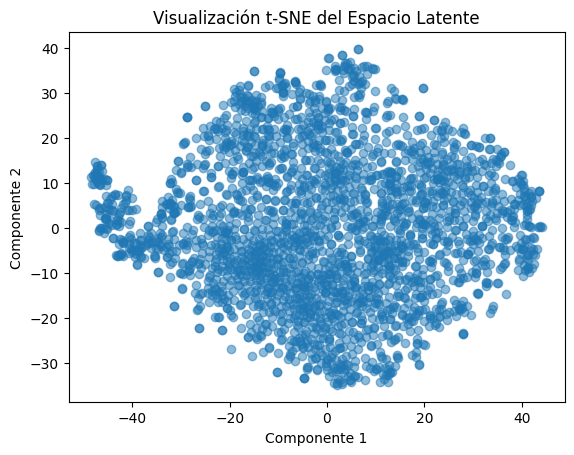

In [5]:
from sklearn.manifold import TSNE

def visualize_latent_space(autoencoder, dataset, device):
    autoencoder.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for noisy_images, _ in DataLoader(dataset, batch_size=32):
            noisy_images = noisy_images.to(device)
            latent = autoencoder.encoder(noisy_images).view(noisy_images.size(0), -1)
            latent_vectors.append(latent.cpu().numpy())
    
    # Concatenar todos los vectores latentes
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(latent_vectors)
    
    # Visualizar
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.title("Visualización t-SNE del Espacio Latente")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.show()

# Llamar a la función de visualización
visualize_latent_space(autoencoder, train_dataset, device)


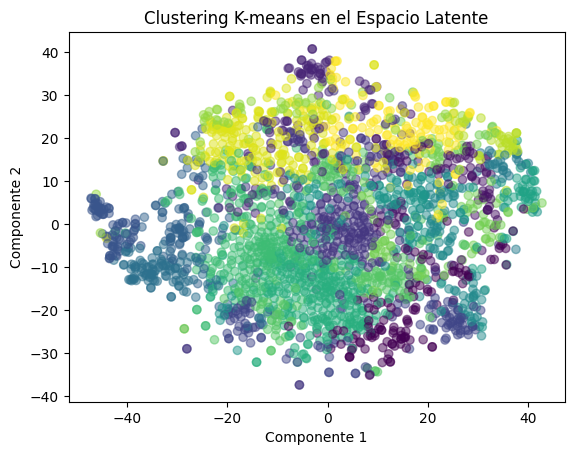

In [6]:
from sklearn.cluster import KMeans

def clustering_latent_space(autoencoder, dataset, device, n_clusters=20):
    autoencoder.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for noisy_images, _ in DataLoader(dataset, batch_size=32):
            noisy_images = noisy_images.to(device)
            latent = autoencoder.encoder(noisy_images).view(noisy_images.size(0), -1)
            latent_vectors.append(latent.cpu().numpy())
    
    # Concatenar todos los vectores latentes
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(latent_vectors)
    
    # Visualizar resultados del clustering en el espacio t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(latent_vectors)
    
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="viridis", alpha=0.5)
    plt.title("Clustering K-means en el Espacio Latente")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.show()

# Llamar a la función de clustering
clustering_latent_space(autoencoder, train_dataset, device, n_clusters=20)
